In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

In [ ]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28, 28, 1), padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False

In [ ]:
ginput = Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer = 'adam')
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         865281    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [ ]:
def gan_train(epoch, batch_size, saving_interval):
  (X_train, _), (_, _) = mnist.load_data()
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')

  X_train = (X_train - 127.5) / 127.5

  true = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for i in range(epoch):
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]
    d_loss_real = discriminator.train_on_batch(imgs, true)

    noise = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(noise)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

    d_loss = 0.5*np.add(d_loss_real, d_loss_fake)
    g_loss = gan.train_on_batch(noise, true)

    print('epoch: %d' %i, 'dloss: %.4f' %d_loss, 'g_loss: %.4f' % g_loss)

    if i% saving_interval == 0:
      noise = np.random.normal(0,1,(25,100))
      gen_imgs = generator.predict(noise)

      gen_imgs = 0.5 * gen_imgs + 0.5

      fig, axs = plt.subplots(5, 5)
      count = 0

      for j in range(5):
        for k in range(5):
          axs[j,k].imshow(gen_imgs[count, :, :, 0], cmap = 'gray')
          axs[j,k].axis('off')
          count += 1
      
      fig.savefig('gan_images/gan_mnist_%d.png' % i)

epoch: 0 dloss: 0.4970 g_loss: 0.3358
epoch: 1 dloss: 0.5645 g_loss: 0.1629
epoch: 2 dloss: 0.5643 g_loss: 0.1613
epoch: 3 dloss: 0.5204 g_loss: 0.2432
epoch: 4 dloss: 0.4653 g_loss: 0.4441
epoch: 5 dloss: 0.4587 g_loss: 0.6200
epoch: 6 dloss: 0.4523 g_loss: 0.7694
epoch: 7 dloss: 0.4510 g_loss: 0.7860
epoch: 8 dloss: 0.4131 g_loss: 0.7921
epoch: 9 dloss: 0.3826 g_loss: 0.8564
epoch: 10 dloss: 0.3980 g_loss: 0.8927
epoch: 11 dloss: 0.2684 g_loss: 1.2485
epoch: 12 dloss: 0.4821 g_loss: 0.9348
epoch: 13 dloss: 0.5505 g_loss: 0.8571
epoch: 14 dloss: 0.6379 g_loss: 0.5968
epoch: 15 dloss: 0.4641 g_loss: 0.7241
epoch: 16 dloss: 0.5692 g_loss: 0.9025
epoch: 17 dloss: 0.5651 g_loss: 0.9180
epoch: 18 dloss: 0.5805 g_loss: 0.7634
epoch: 19 dloss: 0.4985 g_loss: 0.6315
epoch: 20 dloss: 0.4271 g_loss: 0.7351
epoch: 21 dloss: 0.4409 g_loss: 0.9585
epoch: 22 dloss: 0.4891 g_loss: 0.7806
epoch: 23 dloss: 0.4812 g_loss: 0.8017
epoch: 24 dloss: 0.4484 g_loss: 0.7575
epoch: 25 dloss: 0.4941 g_loss: 0.8

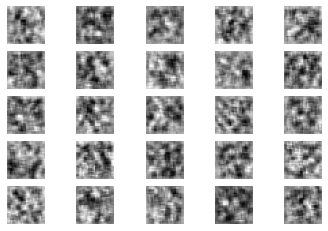

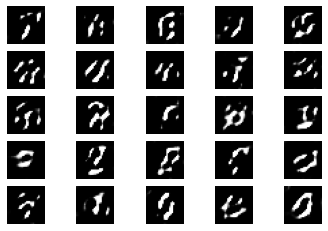

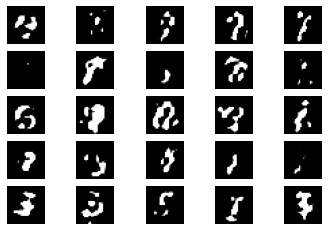

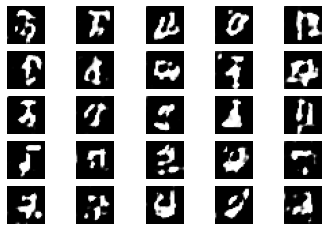

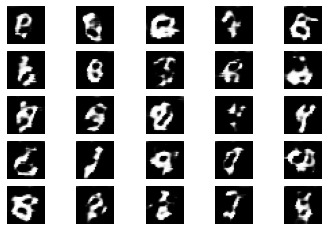

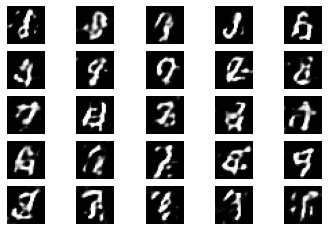

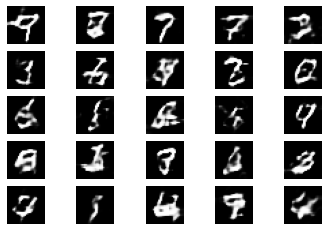

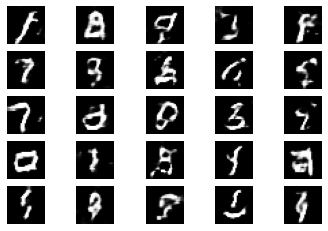

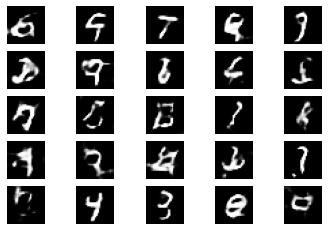

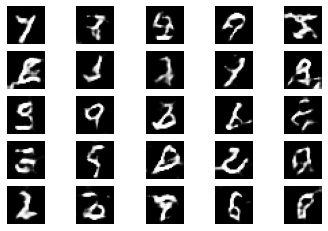

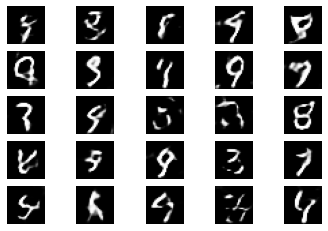

In [ ]:
gan_train(5001, 32, 200)